In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn

# バージョンの情報
import platform
print('The python version is {}.'.format(platform.python_version()))
print('The numpy version is {}.'.format(np.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The python version is 3.7.10.
The numpy version is 1.19.5.
The scikit-learn version is 0.22.2.post1.


# データセットの作成用関数
* sin関数に正規分布のノイズを加えたデータセットを生成する関数
* $0 \leq x \leq 2\pi$ の範囲に等間隔にdata_num個のデータを生成する
* sigmaは正規分布の標準偏差

In [2]:
def create_dataset(data_num, sigma=0.3):
    X = np.linspace(0, 2*np.pi, num=data_num)
    t = np.sin(X) + sigma * np.random.randn(data_num)
    return X, t

## 評価指標を計算する関数
* 決定係数（$R^2$ score）
* 平方根平均二乗誤差（Root mean squre error; RMSE）
* 平均絶対誤差（Mean Absolute Error; MAE）

In [3]:
# t: 正解値，y: 予測値
def RMSE(t, y):
    return np.sqrt(np.mean((y - t)**2))

def R2(t, y):
    return 1 - np.sum((y - t)**2) / np.sum((t - np.mean(t))**2)

def MAE(t, y):
    return np.mean(np.abs(y - t))

# 線形回帰モデル（自作）

##モデルの定義

In [4]:
class LinearRegression(object):    
    # モデルの訓練
    # X: 学習データの入力変数
    # t: 学習データの目的変数
    def fit(self, X, t):
        invP = np.linalg.pinv(X)  # Moore-Penroseの擬似逆行列を求める
        self.w = np.dot(invP, t)
        
        # 一番簡単なのは numpy.linalg.lstsq を使う方法
        #self.w = np.linalg.lstsq(X, t)[0]

        # 以下のように式の通り逆行列を求めても良いが，
        # 基底関数が多くなった場合に計算結果に誤差が出ることがある
        #tmp = np.linalg.inv(np.dot(X.T, X))
        #self.w = np.dot(np.dot(tmp, X.T), t)
    
    # 新しいデータの予測
    # X: 入力変数
    def predict(self, X):
        return np.dot(X, self.w)

## 基底関数の定義

### 多項式

In [5]:
# x^0 から x^(M-1)までの基底関数の値を返す
class Polynomial(object):
    def __init__(self, M=1):
        self.M = M
    
    # Xは （データ数 x 1）もしくは（データ数）のサイズの配列
    def __call__(self, X):
        return np.array([X.flatten()**i for i in range(self.M)]).T

### ガウス基底関数

In [6]:
class GaussianBasis(object):
    def __init__(self, baseMu, s=1.0):
        self.baseMu = baseMu
        self.s = s
    
    # Xは （データ数 x 特徴数）のサイズの配列
    def __call__(self, X):
        if len(X.shape) == 1:
            X = X[:, np.newaxis]
        gbasis = np.array([np.exp(- np.sum((X - mu)**2, axis=1) / (2 * self.s**2)) for mu in self.baseMu]).T
        return gbasis

# データの作成

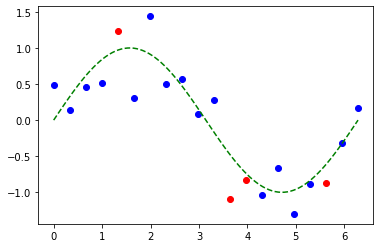

In [7]:
# 乱数シードの固定
np.random.seed(1)

# データの作成
N = 20
orgX, org_t = create_dataset(N)

index = np.arange(N)
np.random.shuffle(index)

# 訓練データ（8割を訓練データに）
X_train, t_train = orgX[index[:int(0.8*N)]], org_t[index[:int(0.8*N)]]
# テスト用データ（残りの2割）
X_test, t_test = orgX[index[int(0.8*N):]], org_t[index[int(0.8*N):]]

# 訓練用データのプロット
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
# テスト用データのプロット
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
# 真の曲線を表示
XX, tt = create_dataset(100, sigma=0.)
plt.plot(XX, tt, color='green', linestyle='--')
plt.show()

# モデルの学習例（多項式回帰）

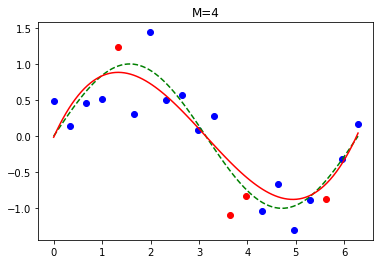

（学習データ）RMSE: 0.335, MAE: 0.276, R2: 0.764
（テストデータ）RMSE: 0.442, MAE: 0.392, R2: 0.779
係数：[-0.01476176  1.4818936  -0.70638064  0.07511567]


In [8]:
# 次数
M = 4

# 線形回帰モデルの学習
Phi = Polynomial(M=M)
lr_model = LinearRegression()
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.title('M=%d'%(M))
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_train, y_train), MAE(t_train, y_train), R2(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_test, y_test), MAE(t_test, y_test), R2(t_test, y_test)))
print('係数：' + str(lr_model.w))

# モデルの学習例（ガウス基底関数の場合）
* ガウス基底関数の場合は特徴量の次元がデータ数分になるため正則化を入れないとパラメータによっては結果が不安定になる

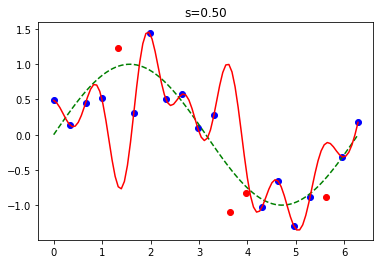

（学習データ）RMSE: 0.000, MAE: 0.000, R2: 1.000
（テストデータ）RMSE: 1.483, MAE: 1.286, R2: -1.479
係数：[  18.55709452  127.9472504   -58.84400963   -7.84060839 -141.76665325
  116.59397463  -36.90207152   17.13694088   37.74126133  -21.10131102
  -31.2112105   -84.25013464   31.08841036   -4.40580402    4.84693492
   33.11133075]


In [9]:
# 線形回帰モデルの学習
s = 0.5
Phi = GaussianBasis(X_train, s=s)
lr_model = LinearRegression()
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.title('s=%.2f'%(s))
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_train, y_train), MAE(t_train, y_train), R2(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_test, y_test), MAE(t_test, y_test), R2(t_test, y_test)))
print('係数：' + str(lr_model.w))

# pythonの機械学習ライブラリscikit-learnを使った場合の線形回帰
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

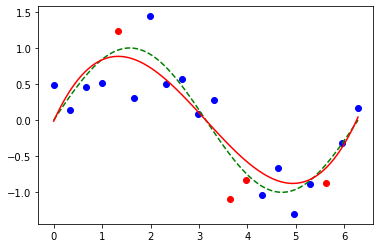

（学習データ）RMSE: 0.335, MAE: 0.276, R2: 0.764
（テストデータ）RMSE: 0.442, MAE: 0.392, R2: 0.779
係数：[-0.01476176  1.4818936  -0.70638064  0.07511567]


In [10]:
import sklearn.linear_model as sk_lm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Phi = Polynomial(M=4)
lr_model = sk_lm.LinearRegression(fit_intercept=False)  # バイアスを無効にする（特徴量に定数x^0が含まれているので）
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
# Scikit-learnの機能を使ってスコアを算出
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_train, y_train)), mean_absolute_error(t_train, y_train), r2_score(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_test, y_test)), mean_absolute_error(t_test, y_test), r2_score(t_test, y_test)))
print('係数：' + str(lr_model.coef_))

---

# 赤ワインのデータ

In [14]:
import pandas as pd
#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=";", encoding="utf-8")
df = pd.read_csv('https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/winequality-red.csv', sep=";", encoding="utf-8")

In [15]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 品質（quality）を予測する
t_org = df['quality'].values
X_org = df.drop(columns='quality').values
 
# データを学習用とテスト用に分割する（Scikit-learnの機能を使う）
X_train, X_test, t_train, t_test = train_test_split(X_org, t_org, test_size=0.2, random_state=0)

# 入力変数を標準化する（各変数が平均0，分散1になるようにスケーリング: (x - mean)/sigma）
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 線形回帰モデルの学習
# ここでは基底関数は使わず元の特徴量をそのまま説明変数として利用する
lr_model = sk_lm.LinearRegression(fit_intercept=True)  # バイアスを有効にする
lr_model.fit(X_train, t_train)
 
# 評価指標の表示
y_train = lr_model.predict(X_train)
y_test = lr_model.predict(X_test)
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_train, y_train), MAE(t_train, y_train), R2(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_test, y_test), MAE(t_test, y_test), R2(t_test, y_test)))
print('係数：')
for i, n in enumerate(df.drop(columns='quality').columns):
    print(n + ': %.4f'%(lr_model.coef_[i]))
print('切片：' + str(lr_model.intercept_))

（学習データ）RMSE: 0.653, MAE: 0.510, R2: 0.365
（テストデータ）RMSE: 0.620, MAE: 0.470, R2: 0.328
係数：
fixed acidity: 0.0716
volatile acidity: -0.2098
citric acid: -0.0348
residual sugar: 0.0405
chlorides: -0.0895
free sulfur dioxide: 0.0282
total sulfur dioxide: -0.0932
density: -0.0593
pH: -0.0392
sulphates: 0.1615
alcohol: 0.2841
切片：5.646598905394848
